In [231]:
# importing modules and other tools necessary for analaysis"
import pandas as pd
import env
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_db_url(database):
        url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/{database}'
        return url

def get_zillow():
    sql = """
            SELECT properties_2017.*
            , predictions_2017.logerror
            FROM properties_2017
            LEFT JOIN predictions_2017 USING(parcelid)
            WHERE predictions_2017.transactiondate LIKE '2017%%' AND properties_2017.propertylandusetypeid = 261;
          """
    url = get_db_url('zillow')
    zillow_df = pd.read_sql(sql, url)
    return zillow_df
    
def read_zillow_data():
    """This function reads in the zillow dataset from the CodeUp db, writes data to a csv 
    file if a local file does not exist, and returns a df"""
    if os.path.isfile('zillow_df.csv'):
    # If csv file exists, read in data from csv file.\n",
        df = pd.read_csv('zillow_df.csv', index_col = 0)
    else:
    # Read fresh data from db into a DataFrame.
        df = get_zillow()
    # Write DataFrame to a csv file.
        df.to_csv('zillow_df.csv')
    return df

In [3]:
df = read_zillow_data()
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410
4,781532,12095076,1.0,NaN,NaN,3.0,4.0,NaN,9.0,3.0,...,NaN,276684.0,773303.0,2016.0,496619.0,9516.26,NaN,NaN,6.037461e+13,-0.001011


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52441 non-null  int64  
 1   parcelid                      52441 non-null  int64  
 2   airconditioningtypeid         13638 non-null  float64
 3   architecturalstyletypeid      70 non-null     float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   52441 non-null  float64
 6   bedroomcnt                    52441 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         33740 non-null  float64
 9   calculatedbathnbr             52304 non-null  float64
 10  decktypeid                    389 non-null    float64
 11  finishedfloor1squarefeet      4381 non-null   float64
 12  calculatedfinishedsquarefeet  52359 non-null  float64
 13  f

In [5]:
df.isnull().sum()

id                                  0
parcelid                            0
airconditioningtypeid           38803
architecturalstyletypeid        52371
basementsqft                    52394
bathroomcnt                         0
bedroomcnt                          0
buildingclasstypeid             52441
buildingqualitytypeid           18701
calculatedbathnbr                 137
decktypeid                      52052
finishedfloor1squarefeet        48060
calculatedfinishedsquarefeet       82
finishedsquarefeet12              247
finishedsquarefeet13            52441
finishedsquarefeet15            52441
finishedsquarefeet50            48060
finishedsquarefeet6             52276
fips                                0
fireplacecnt                    45198
fullbathcnt                       137
garagecarcnt                    34426
garagetotalsqft                 34426
hashottuborspa                  50926
heatingorsystemtypeid           18506
latitude                            0
longitude   

In [6]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    pct_missing = num_missing / rows
    cols_missing = pd.DataFrame({'number_missing_rows': num_missing, 'percent_rows_missing': pct_missing})
    return cols_missing

In [7]:
missing_cols = nulls_by_col(df)
missing_cols.T

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror
number_missing_rows,0.0,0.0,38803.000000,52371.000000,52394.000000,0.0,0.0,52441.0,18701.00000,137.000000,...,52360.000000,84.000000,1.000000,0.0,1.000000,4.000000,50362.000000,50362.000000,123.000000,0.0
percent_rows_missing,0.0,0.0,0.739936,0.998665,0.999104,0.0,0.0,1.0,0.35661,0.002612,...,0.998455,0.001602,0.000019,0.0,0.000019,0.000076,0.960355,0.960355,0.002345,0.0


In [8]:
# let's drop columns with missing values greater than 20%
df.drop(columns = missing_cols[missing_cols.percent_rows_missing > .2].T, inplace = True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52441 non-null  int64  
 1   parcelid                      52441 non-null  int64  
 2   bathroomcnt                   52441 non-null  float64
 3   bedroomcnt                    52441 non-null  float64
 4   calculatedbathnbr             52304 non-null  float64
 5   calculatedfinishedsquarefeet  52359 non-null  float64
 6   finishedsquarefeet12          52194 non-null  float64
 7   fips                          52441 non-null  float64
 8   fullbathcnt                   52304 non-null  float64
 9   latitude                      52441 non-null  float64
 10  longitude                     52441 non-null  float64
 11  lotsizesquarefeet             52072 non-null  float64
 12  propertycountylandusecode     52441 non-null  object 
 13  p

In [10]:
df.isnull().sum().sum()

2364

In [11]:
# let's go ahead and drop the nulls
df = df.dropna()
df.isnull().sum()

id                              0
parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
propertylandusetypeid           0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
dtype: int64

In [12]:
# propertylandusetypeid can be dropped since this feature doesn't add much other than being
# a filter for the db query
df.drop(columns = 'propertylandusetypeid', inplace = True)

In [13]:
# dropping id, parcelid, propertycountylandusecode, regionidcity, regionidcounty, 
# finishedsquarefeet12, fullbathcnt, calculatedbathnbr, and assessmentyear
df.drop(columns = ['id', 'parcelid', 'propertycountylandusecode', 'regionidcity', 'regionidcounty', 'finishedsquarefeet12', 'assessmentyear', 'fullbathcnt', 'calculatedbathnbr'], inplace = True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50673 entries, 0 to 52440
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            50673 non-null  int64  
 1   bathroomcnt                   50673 non-null  float64
 2   bedroomcnt                    50673 non-null  float64
 3   calculatedfinishedsquarefeet  50673 non-null  float64
 4   fips                          50673 non-null  float64
 5   latitude                      50673 non-null  float64
 6   longitude                     50673 non-null  float64
 7   lotsizesquarefeet             50673 non-null  float64
 8   rawcensustractandblock        50673 non-null  float64
 9   regionidzip                   50673 non-null  float64
 10  roomcnt                       50673 non-null  float64
 11  yearbuilt                     50673 non-null  float64
 12  structuretaxvaluedollarcnt    50673 non-null  float64
 13  t

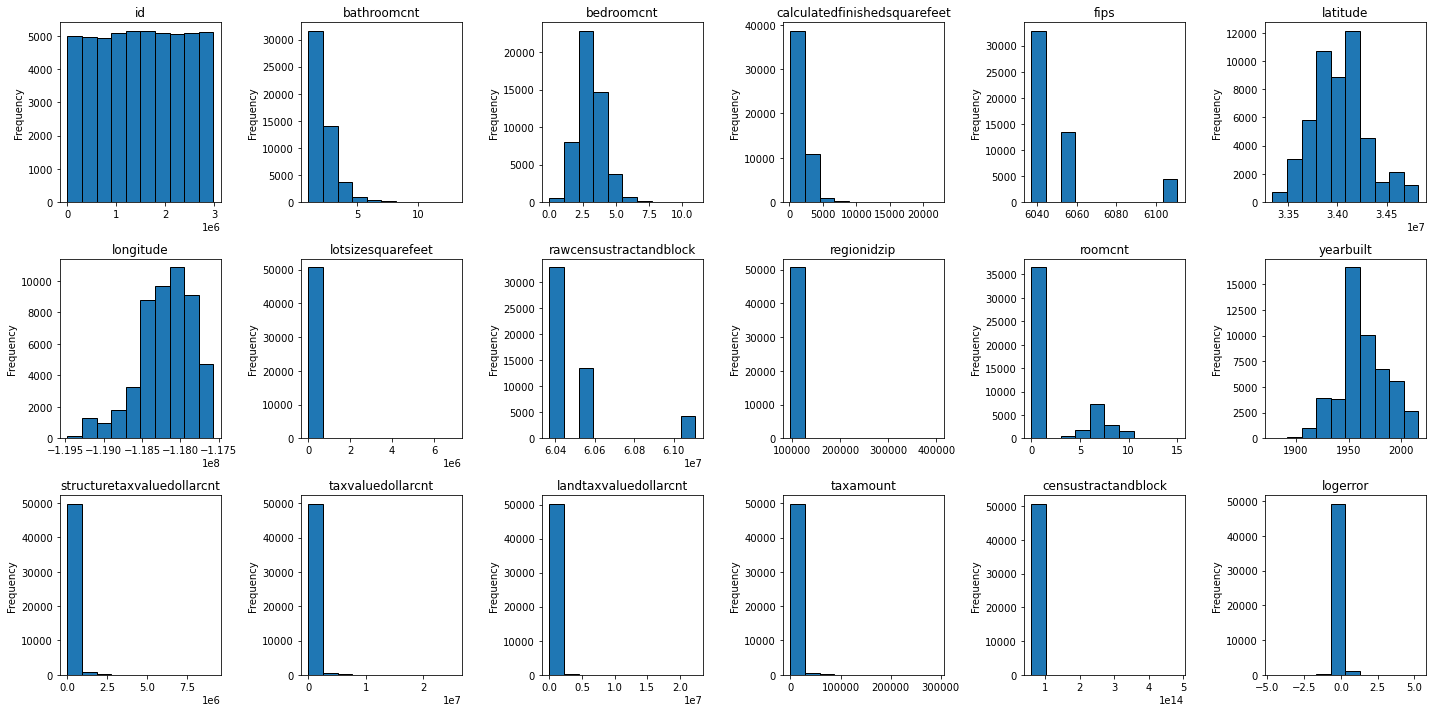

In [15]:
fig, axs = plt.subplots(3, 6, figsize = (20, 10))
fl_ax = axs.ravel()
for i, col in enumerate(df.select_dtypes(exclude = 'object').columns):
    df[col].plot.hist(ax = fl_ax[i], title = col, ec = 'black')
    plt.tight_layout()

In [16]:
# remove outliers
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis = 1)
df = df[filtered_entries]


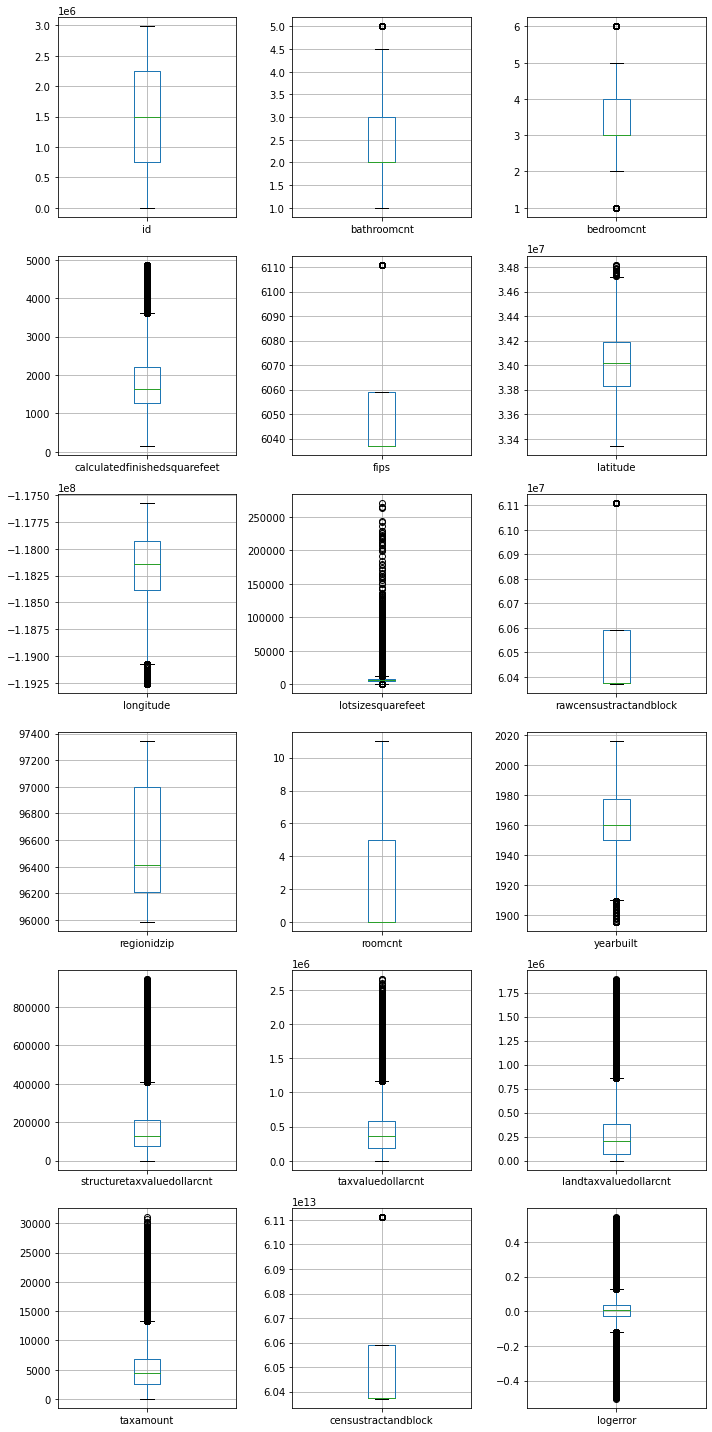

In [17]:
# let's iron out any outliers
fig, axs = plt.subplots(6, 3, figsize = (10, 20))
fl_ax = axs.ravel()
for i, col in enumerate(df.select_dtypes(exclude = 'object').columns):
    df.boxplot(col, ax = fl_ax[i])
    plt.tight_layout()

In [18]:
# Add column for counties
df['county'] = np.where(df.fips == 6037, 'Los_Angeles', np.where(df.fips == 6059, 'Orange', 'Ventura'))
df.drop(columns = 'fips', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47897 entries, 0 to 52440
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            47897 non-null  int64  
 1   bathroomcnt                   47897 non-null  float64
 2   bedroomcnt                    47897 non-null  float64
 3   calculatedfinishedsquarefeet  47897 non-null  float64
 4   latitude                      47897 non-null  float64
 5   longitude                     47897 non-null  float64
 6   lotsizesquarefeet             47897 non-null  float64
 7   rawcensustractandblock        47897 non-null  float64
 8   regionidzip                   47897 non-null  float64
 9   roomcnt                       47897 non-null  float64
 10  yearbuilt                     47897 non-null  float64
 11  structuretaxvaluedollarcnt    47897 non-null  float64
 12  taxvaluedollarcnt             47897 non-null  float64
 13  l

#### Questions to check out

1. Does latitude and longitude have a relationship to logerror?
2. Does the number of rooms affect logerror?
3. Does finished square footage affect logerror?
4. Does lotsizesquarefeet have a relationship to logerror?
5. How different are the logerrors for the three counties in the dataset?

In [19]:
# split dataset into train, validate, test
train_and_validate, test = train_test_split(df, random_state = 123)
train, validate = train_test_split(train_and_validate)

In [20]:
train.shape, validate.shape, test.shape

((26941, 18), (8981, 18), (11975, 18))

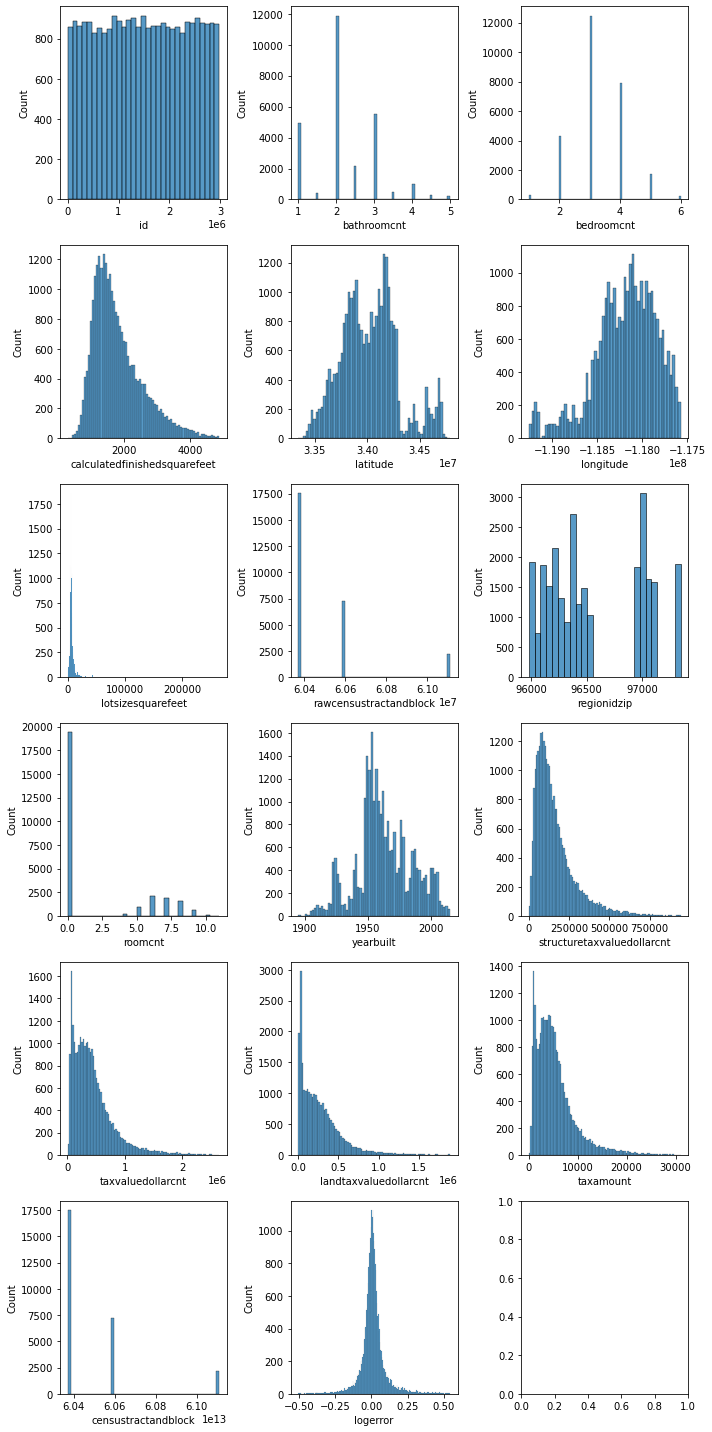

In [21]:
# univariate visualizations
fig, axs = plt.subplots(6, 3, figsize = (10, 20))
fl_ax = axs.ravel()
for i, col in enumerate(train.select_dtypes(exclude = 'object').columns):
    sns.histplot(data = train[col], ax = fl_ax[i])
    plt.tight_layout()

In [22]:
df.roomcnt.value_counts()

0.0     34500
6.0      3734
7.0      3415
8.0      2691
5.0      1697
9.0      1102
4.0       374
10.0      286
11.0       54
3.0        36
2.0         7
1.0         1
Name: roomcnt, dtype: int64

#### Takeaways
- bathroocnt distribution skews right
- bedroomcnt distribution looks normal
- calculatedfinishedsquarefeet distribution looks skewed right
- fullbathcnt distribution skews right
### - roomcnt feature might need to get dropped in a second run through as there are over 30K rows with 0 roomcnt
- yearbuilt seems to follow a normal distribution
- structuretaxvaluedollarcnt, taxvaluedollarcnt, taxamount, landtaxvaluedollarcnt has a right-skewed distribution
- logerror has a normal distribution

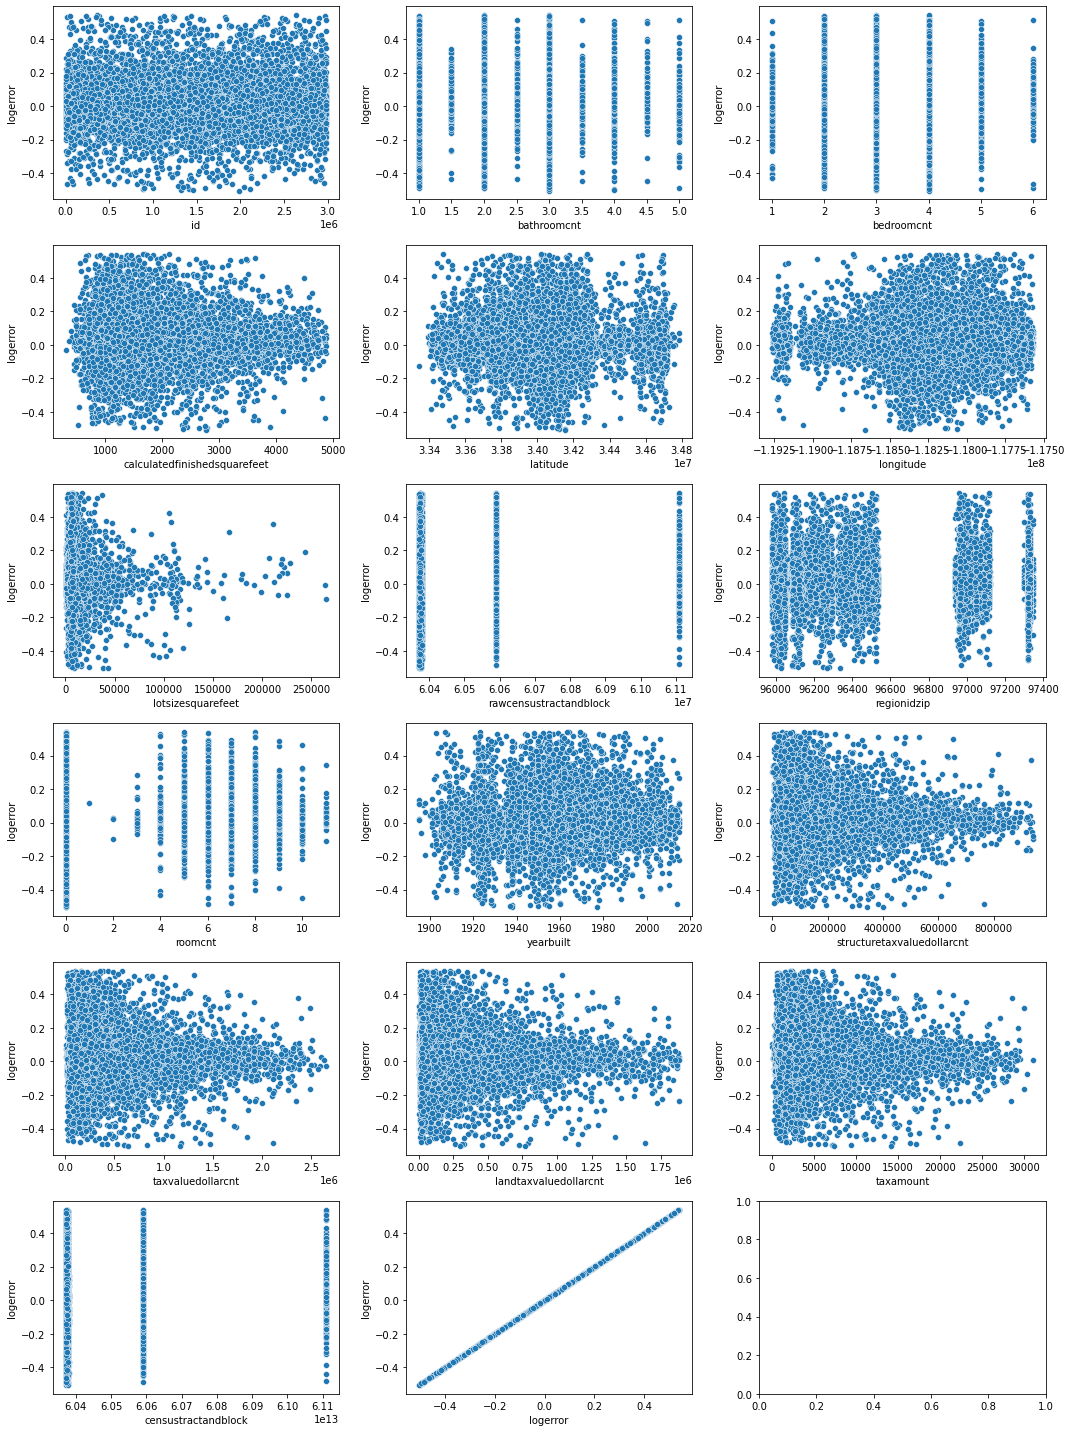

In [23]:
# bivariate visualizations

fig, axs = plt.subplots(6, 3, figsize = (15, 20))
fl_ax = axs.ravel()
for i, col in enumerate(train.select_dtypes(exclude = 'object').columns):
    sns.scatterplot(x = train[col], y = train['logerror'], ax = fl_ax[i])
    plt.tight_layout()

#### Takeaways
- The scatterplots comparing the target variable with the other features do not seem to show a strong relationship, at least for now.
- The only possible exception being lotsizesquare which shows one main cluster with two faint clusters as square feet increases. 

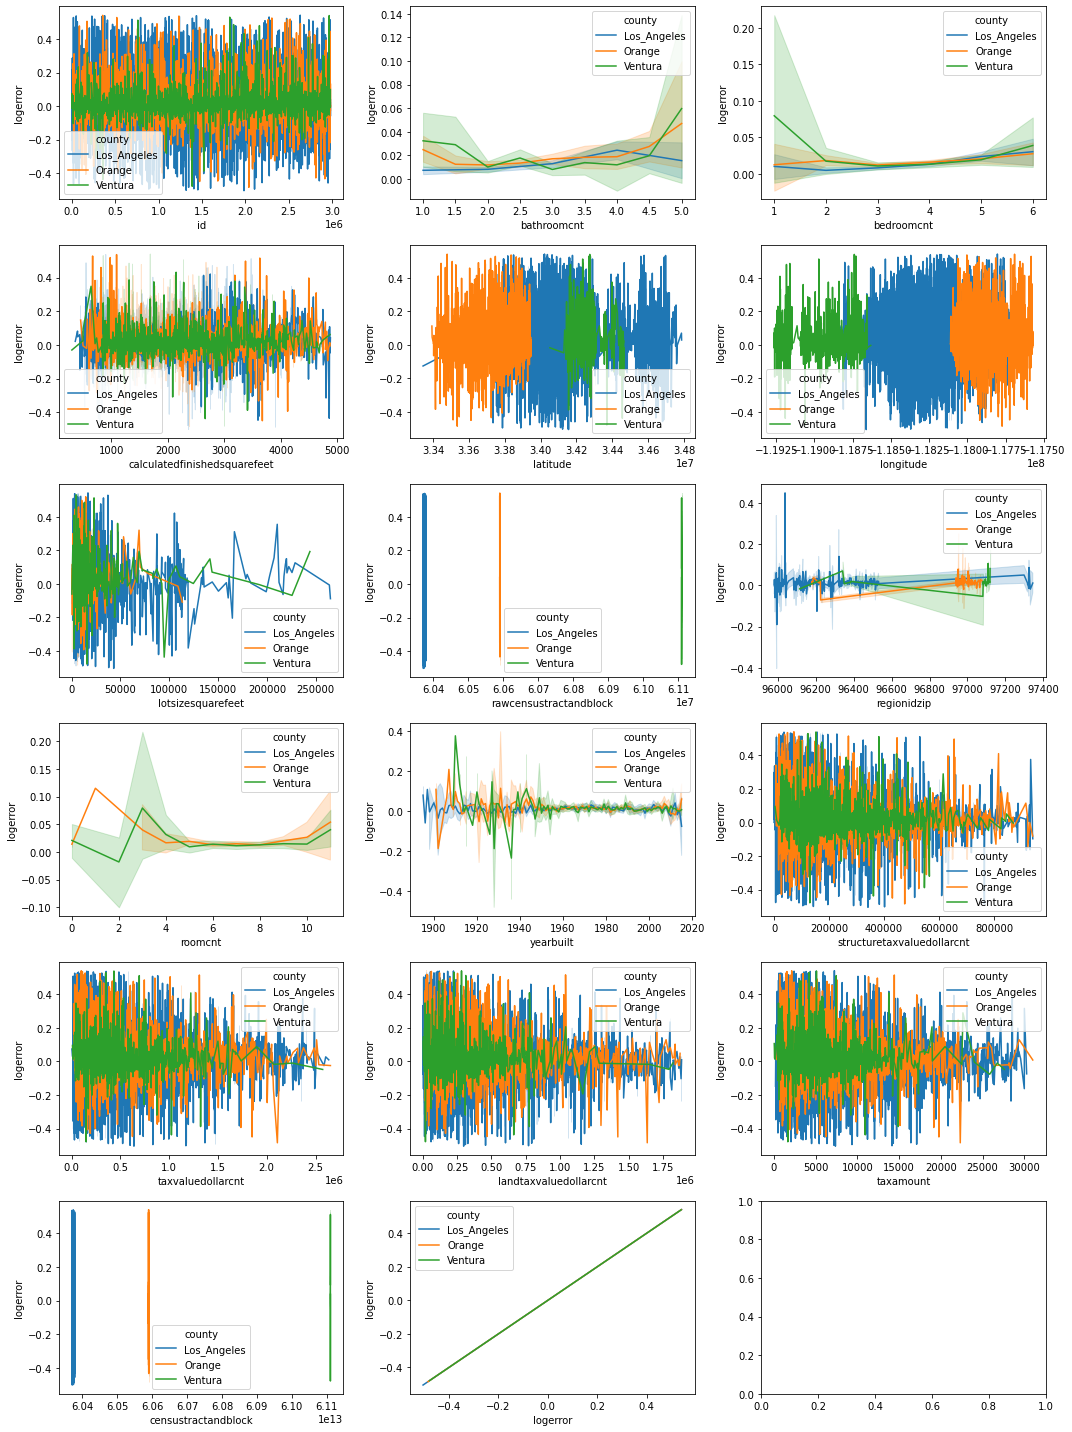

In [24]:
# multivariate
fig, axs = plt.subplots(6, 3, figsize = (15, 20))
fl_ax = axs.ravel()
for i, col in enumerate(train.select_dtypes(exclude = 'object').columns):
    sns.lineplot(x = train[col], y = train['logerror'], data = train, ax = fl_ax[i], hue = train['county'])
    plt.tight_layout()

#### Takeaways
- Most lineplots seem to follow a similar progression along x-axis, wit a few exceptions, regardless of county.
- There is a clear hue distinction in the latitude, longitude and censustractandblock charts (makes sense given geographical implication).
- line plots for the tax features (structuretaxvaluedollarcnt, taxvaluedollarcnt, landtaxvaluedollarcnt, and taxamount) are very very similar to each other.

#### Question 1 - Does latitude + longitude have a relationship to logerror?

In [172]:
train_cluster = train[['latitude', 'longitude']]
X = train_cluster
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)
train_cluster['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = ['latitude', 'longitude'])
train_cluster.groupby('cluster')['latitude', 'longitude'].mean()

,latitude,longitude
cluster,,
0,3.381778e+07,-1.179092e+08
1,3.423505e+07,-1.188738e+08
2,3.418211e+07,-1.183033e+08


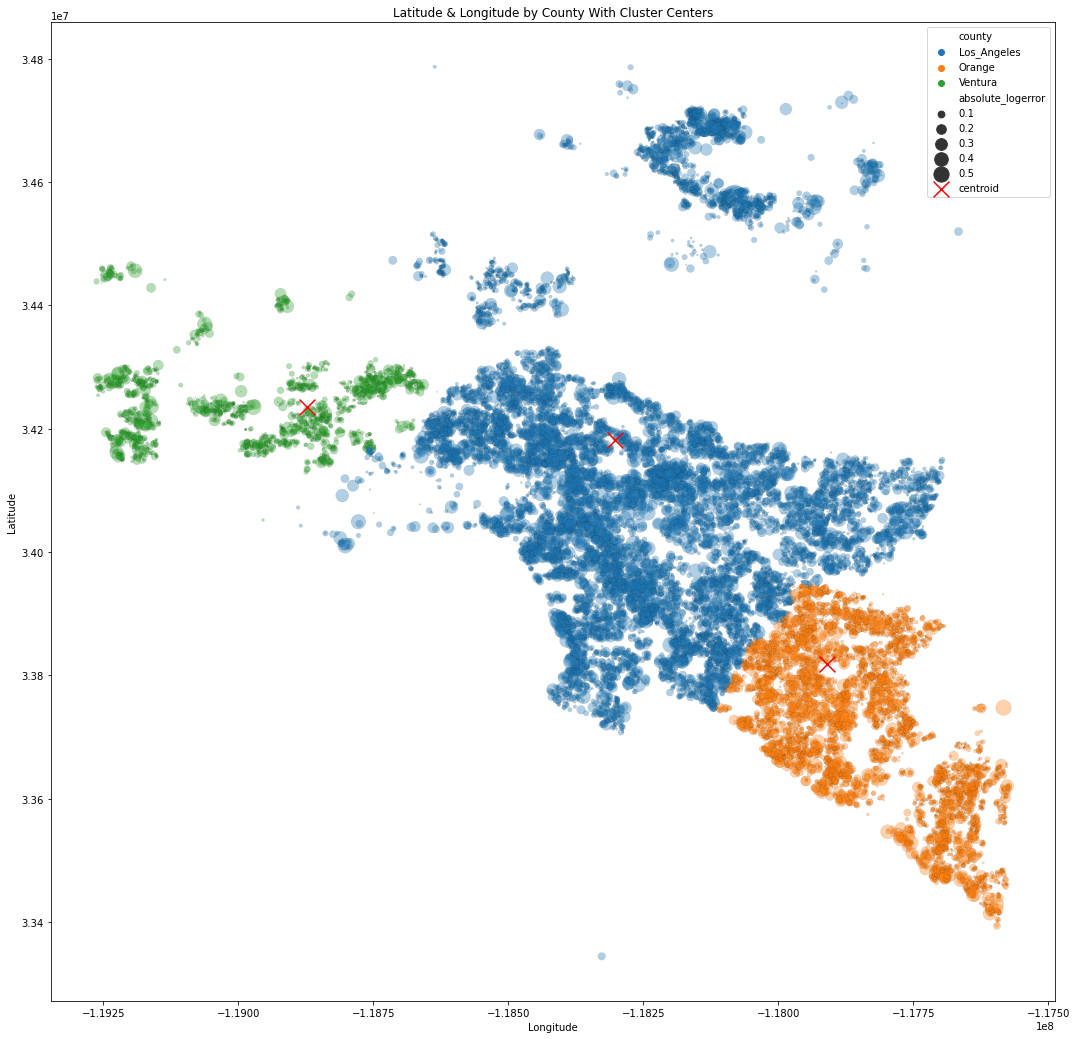

In [178]:
train['absolute_logerror'] = abs(train['logerror'])
plt.figure(figsize = (18, 18))
sns.scatterplot(x = 'longitude', y = 'latitude', hue = 'county', data = train, ec = 'black', linewidth = 0.15, alpha = 0.35, size = 'absolute_logerror', sizes = (0, 250))
centroids.plot.scatter(x = 'longitude', y = 'latitude', c = 'red', marker = 'x', s = 250, ax = plt.gca(), label = 'centroid')
plt.legend()
plt.title('Latitude & Longitude by County With Cluster Centers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
train.drop(columns = ['absolute_logerror'], inplace = True)

#### Takeaways
- The majority of errors follows dataset population: LA then Orange, then Ventura
- There seems to be bigger logerror concentrations in LA compared to the other two counties but it might be because there's more datapoints in LA.
- There isn't a clear relationship between logerror and latitude and longitude

#### Question 2 - Does county location impact logerror?

#### ANOVA Statistical Test: comparing means of logerror by county

**Set Hypothesis**

$H_{0}$: County location does not affect logerror

$H_{a}$: County location does affect logerror

**Verify Assumptions**
 - Normal Distribution? **yes**
 - Independent Samples? **yes**
 - Equal Variances? **yes**

In [182]:
alpha = 0.05
la_county_le = train[train.county == 'Los_Angeles'].logerror
orange_county_le = train[train.county == 'Ventura'].logerror
ventura_county_le = train[train.county == 'Orange'].logerror

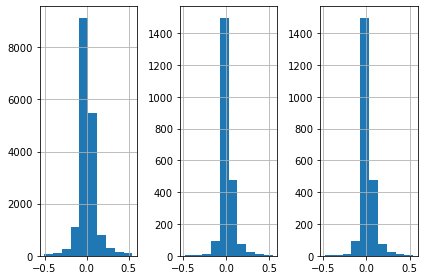

In [181]:
plt.subplot(1,3,1)
la_county_le.hist()
plt.subplot(1,3,2)
orange_county_le.hist()
plt.subplot(1,3,3)
orange_county_le.hist()
plt.tight_layout();

In [29]:
print(la_county_le.var())
print(orange_county_le.var())
print(ventura_county_le.var())

0.009958487270287251
0.0053342754070523765
0.006426070308668958


In [30]:
f, p = stats.f_oneway(la_county_le, orange_county_le, ventura_county_le)
f, p

(8.647912389008335, 0.00017598050511124944)

In [31]:
if p < alpha:
    print("We reject $H_{0}$")
else:
    print("We fail to reject $H_{0}$")

We reject $H_{0}$


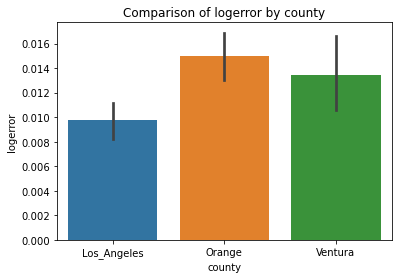

In [32]:
# let's do a visualization of logerror by county
sns.barplot(data = train, x = 'county', y = 'logerror')
plt.title('Comparison of logerror by county');

The anova statistical test tells us that the county location does affect the logerror amount for these zillow postings.

#### Question 3 - Does the number of rooms affect logerror?

In [33]:
train.bedroomcnt.value_counts()

3.0    12478
4.0     7931
2.0     4310
5.0     1725
1.0      274
6.0      223
Name: bedroomcnt, dtype: int64

In [34]:
# let's bin the roomcnt feature into room groups.
train['bedroomcnt_binned'] = pd.cut(train.bedroomcnt, [0, 1, 2, 3, 4, 5, 6])

#### ANOVA Statistical Test: comparing means of logerror by room

**Set Hypothesis**

$H_{0}$: The logerror for properties with X number of rooms is not different from the population logerror.

$H_{a}$: The logerror for properties with X number of rooms is  different from the population logerror.

**Verify Assumptions**
 - Normal Distribution? **yes**
 - Independent Samples? **yes**
 - Equal Variances? **yes**

In [37]:
one_b = train[train.bedroomcnt == 1.0].logerror
two_b = train[train.bedroomcnt == 2.0].logerror
three_b = train[train.bedroomcnt == 3.0].logerror
four_b = train[train.bedroomcnt == 4.0].logerror
five_b = train[train.bedroomcnt == 5.0].logerror
six_b = train[train.bedroomcnt == 6.0].logerror

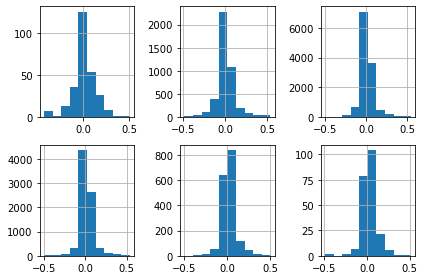

In [38]:
plt.subplot(2, 3, 1)
one_b.hist()
plt.subplot(2, 3, 2)
two_b.hist()
plt.subplot(2, 3, 3)
three_b.hist()
plt.subplot(2, 3, 4)
four_b.hist()
plt.subplot(2, 3, 5)
five_b.hist()
plt.subplot(2, 3, 6)
six_b.hist()
plt.tight_layout()

In [39]:
print(one_b.var())
print(two_b.var())
print(three_b.var())
print(four_b.var())
print(five_b.var())
print(six_b.var())

0.016583003793867474
0.012808890133314745
0.008023722620339865
0.007301046240675407
0.007248269889646145
0.00936489166383733


In [40]:
f, p = stats.f_oneway(one_b, two_b, three_b, four_b, five_b, six_b)
f, p

(10.536082982220352, 4.0025159389308434e-10)

In [41]:
if p < alpha:
    print("We reject $H_{0}$")
else:
    print("We fail to reject $H_{0}$")

We reject $H_{0}$


In [36]:
train.drop(columns = ['bedroomcnt_binned'], inplace = True)

#### Question 4 - How are finished square footage and logerror related?

Text(0.5, 1.0, 'Change in inertia as k increases')

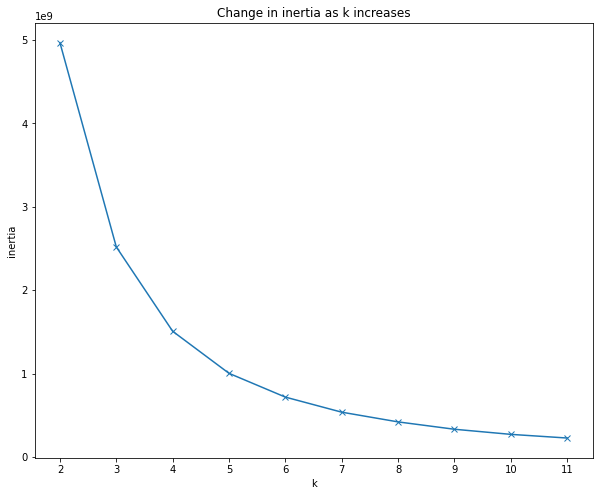

In [284]:
# elbow method to calculate ideal number of k
cluster_one = train[['calculatedfinishedsquarefeet', 'logerror']]
kmeans = KMeans(n_clusters = 5)
kmeans.fit(cluster_one)
plt.figure(figsize = (10, 8))
pd.Series({k: KMeans(k).fit(cluster_one).inertia_ for k in range(2, 12)}).plot(marker = 'x')
plt.xticks(range(2, 12))
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Change in inertia as k increases')

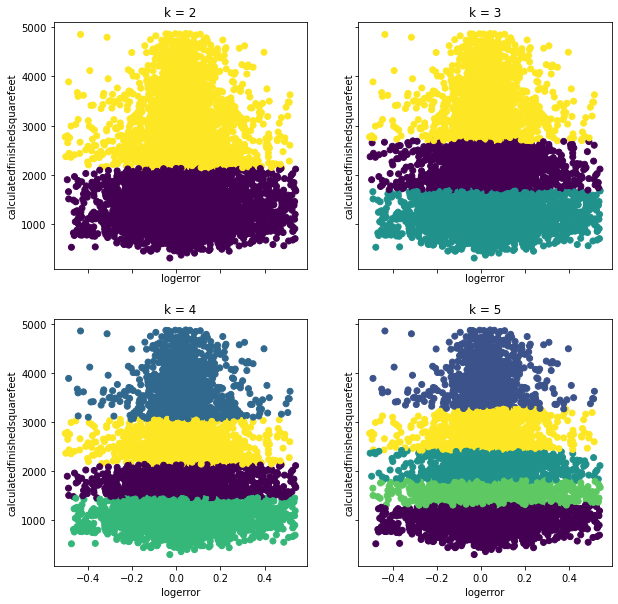

In [216]:
# it looks like k = 5 is ideal
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex = True, sharey = True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(cluster_one).predict(cluster_one)
    ax.scatter(cluster_one.logerror, cluster_one.calculatedfinishedsquarefeet, c = clusters)
    ax.set(title='k = {}'.format(k), xlabel = 'logerror', ylabel = 'calculatedfinishedsquarefeet')

In [43]:
train.calculatedfinishedsquarefeet.describe()

count    26941.000000
mean      1813.275936
std        751.831048
min        300.000000
25%       1263.000000
50%       1632.000000
75%       2202.000000
max       4876.000000
Name: calculatedfinishedsquarefeet, dtype: float64

In [57]:
# let's bin the roomcnt feature into room groups.
train['calculatedfinishedsquarefeet_binned'] = pd.cut(train.calculatedfinishedsquarefeet, [0, 1262, 1628, 2199, 4876])

In [45]:
train.calculatedfinishedsquarefeet_binned.value_counts()

(1628, 2199]    6768
(2199, 4876]    6763
(0, 1262]       6729
(1262, 1628]    6681
Name: calculatedfinishedsquarefeet_binned, dtype: int64

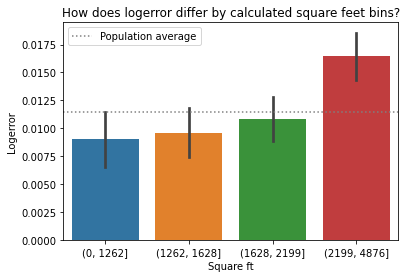

In [46]:
sns.barplot(y = train.logerror, x = train.calculatedfinishedsquarefeet_binned)
plt.title('How does logerror differ by calculated square feet bins?')
plt.xlabel('Square ft')
plt.ylabel('Logerror')
plt.axhline(y = train.logerror.mean(), ls = ':', color = 'gray', label = 'Population average')
plt.legend();

In [60]:
# let's convert binned categories into strings so that we can assign variables
train.calculatedfinishedsquarefeet_binned = train.calculatedfinishedsquarefeet_binned.astype('string')

In [62]:
train.calculatedfinishedsquarefeet_binned.value_counts()

(1628, 2199]    6768
(2199, 4876]    6763
(0, 1262]       6729
(1262, 1628]    6681
Name: calculatedfinishedsquarefeet_binned, dtype: Int64

In [63]:
quart_one = train[train.calculatedfinishedsquarefeet_binned == '(0, 1262]'].logerror
quart_two = train[train.calculatedfinishedsquarefeet_binned == '(1262, 1628]'].logerror
quart_three = train[train.calculatedfinishedsquarefeet_binned == '(1628, 2199]'].logerror
quart_four = train[train.calculatedfinishedsquarefeet_binned == '(2199, 4876]'].logerror

<AxesSubplot:>

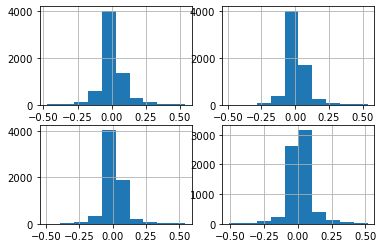

In [64]:
plt.subplot(2, 2, 1)
quart_one.hist()
plt.subplot(2, 2, 2)
quart_two.hist()
plt.subplot(2, 2, 3)
quart_three.hist()
plt.subplot(2, 2, 4)
quart_four.hist()

In [65]:
print(quart_one.var())
print(quart_two.var())
print(quart_three.var())
print(quart_four.var())

0.011211207482255412
0.007924534775811495
0.007093997465026636
0.008304376213636068


#### ANOVA Statistical Test: comparing means of logerror by square feet

**Set Hypothesis**

$H_{0}$: Logerror mean does not differ for homes with different square-footage

$H_{a}$: Logerror mean does differ for homes with different square-footage

**Verify Assumptions**
 - Normal Distribution? **yes**
 - Independent Samples? **yes**
 - Equal Variances? **sorta, but small enough**

In [66]:
f, p = stats.f_oneway(quart_one, quart_two, quart_three, quart_four)
f, p

(9.080622464861614, 5.272148756620808e-06)

In [67]:
if p < alpha:
    print("We reject $H_{0}$")
else:
    print("We fail to reject $H_{0}$")

We reject $H_{0}$


In [96]:
train.drop(columns = ['calculatedfinishedsquarefeet_binned'], inplace = True)

#### Takeaways
 - We can see that logerror increases as square feet increase
 - Interesting that the bottom three quartiles are below the average but the last quartile isn't

#### Questions 5 - How are lot size and logerror related?

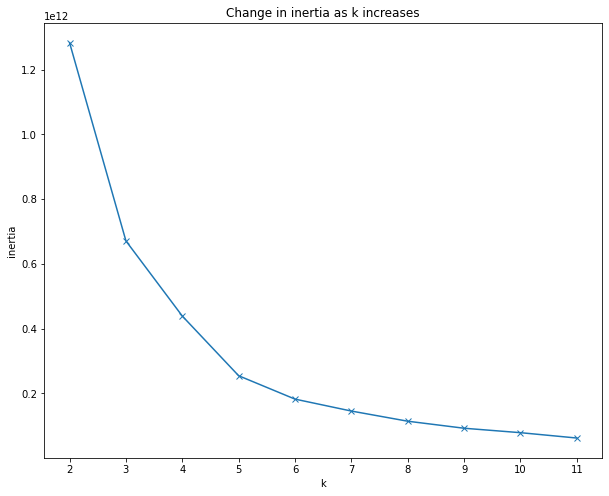

In [212]:
# elbow method to calculate ideal number of k
cluster_two = train[['lotsizesquarefeet', 'logerror']]
kmeans = KMeans(n_clusters = 5)
kmeans.fit(cluster_two)
plt.figure(figsize = (10, 8))
pd.Series({k: KMeans(k).fit(cluster_two).inertia_ for k in range(2, 12)}).plot(marker = 'x')
plt.xticks(range(2, 12))
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Change in inertia as k increases')
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = cluster_two.columns)

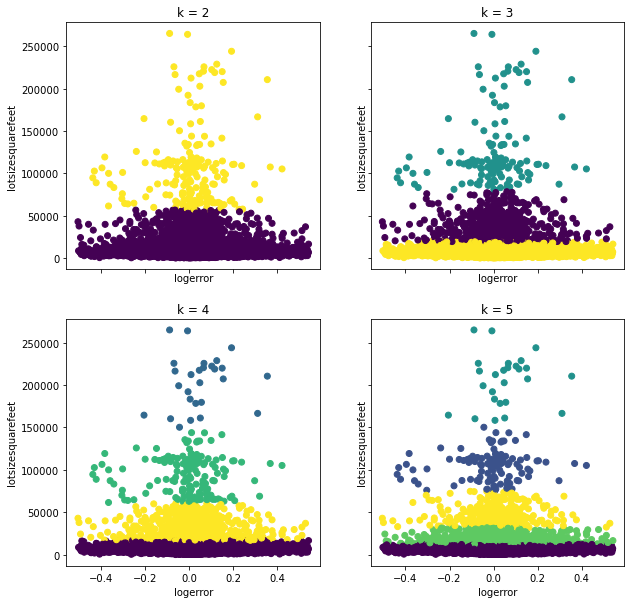

In [214]:
# it looks like k = 5 is ideal
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex = True, sharey = True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(cluster_two).predict(cluster_two)
    ax.scatter(cluster_two.logerror, cluster_two.lotsizesquarefeet, c = clusters)
    ax.set(title = 'k = {}'.format(k), xlabel = 'logerror', ylabel = 'lotsizesquarefeet')

In [68]:
train.lotsizesquarefeet.describe()

count     26941.000000
mean       8776.560298
std       10919.768704
min         236.000000
25%        5531.000000
50%        6752.000000
75%        8466.000000
max      264945.000000
Name: lotsizesquarefeet, dtype: float64

In [69]:
train['lotsizesquarefeet_binned'] = pd.cut(train.lotsizesquarefeet, [0, 5531, 6752, 8466, 264945])

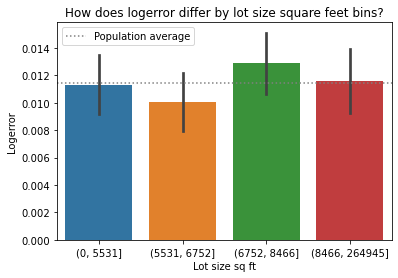

In [71]:
sns.barplot(y = train.logerror, x = train.lotsizesquarefeet_binned)
plt.title('How does logerror differ by lot size square feet bins?')
plt.xlabel('Lot size sq ft')
plt.ylabel('Logerror')
plt.axhline(y = train.logerror.mean(), ls = ':', color = 'gray', label = 'Population average')
plt.legend();

In [72]:
# let's convert binned categories into strings so that we can assign variables
train.lotsizesquarefeet_binned = train.lotsizesquarefeet_binned.astype('string')

In [90]:
train.lotsizesquarefeet_binned.value_counts()

(5531, 6752]      6740
(0, 5531]         6736
(8466, 264945]    6735
(6752, 8466]      6730
Name: lotsizesquarefeet_binned, dtype: Int64

In [92]:
quart_one = train[train.lotsizesquarefeet_binned == '(0, 5531]'].logerror
quart_two = train[train.lotsizesquarefeet_binned == '(5531, 6752]'].logerror
quart_three = train[train.lotsizesquarefeet_binned == '(6752, 8466]'].logerror
quart_four = train[train.lotsizesquarefeet_binned == '(8466, 264945]'].logerror

<AxesSubplot:>

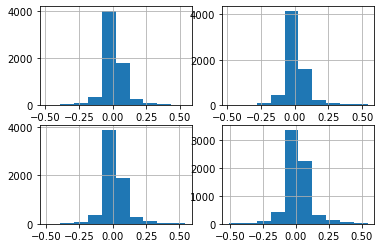

In [93]:
plt.subplot(2, 2, 1)
quart_one.hist()
plt.subplot(2, 2, 2)
quart_two.hist()
plt.subplot(2, 2, 3)
quart_three.hist()
plt.subplot(2, 2, 4)
quart_four.hist()

In [94]:
print(quart_one.var())
print(quart_two.var())
print(quart_three.var())
print(quart_four.var())

0.00805130675452234
0.008609708348065277
0.008081189149793845
0.009816838580472158


#### ANOVA Statistical Test: comparing means of logerror by lot size

**Set Hypothesis**

$H_{0}$: Logerror population mean for lot size quartiles are equal

$H_{a}$: Logerror population mean for lot size quartiles are not equal

**Verify Assumptions**
 - Normal Distribution? **yes**
 - Independent Samples? **yes**
 - Equal Variances? **yes**

In [97]:
f, p = stats.f_oneway(quart_one, quart_two, quart_three, quart_four)
f, p

(1.0816768844544533, 0.3553861045545829)

In [98]:
if p < alpha:
    print("We reject $H_{0}$")
else:
    print("We fail to reject $H_{0}$")

We fail to reject $H_{0}$


In [99]:
train.drop(columns = ['lotsizesquarefeet_binned'], inplace = True)

#### Takaways:
 - logerror is comparable across binned lot sizes

In [246]:
# modeling
train_sc = train.drop(columns = ['county'])
validate_sc = validate.drop(columns = ['county'])
test_sc = test.drop(columns = ['county'])
num_cols = list(train_sc.columns)

# scaling

#scaler = StandardScaler()

#train_sc[num_cols] = scaler.fit_transform(train_sc[num_cols])
#validate_sc[num_cols] = scaler.transform(validate_sc[num_cols])
#test_sc[num_cols] = scaler.transform(test_sc[num_cols])

In [247]:
# adding back county column
train_sc = pd.concat([train_sc, train.county], axis = 1)
validate_sc = pd.concat([validate_sc, validate.county], axis = 1)
test_sc = pd.concat([test_sc, test.county], axis = 1)

In [248]:
# encode county column
train_sc = pd.concat([train_sc, pd.get_dummies(train_sc.county, drop_first = False)], axis = 1)
validate_sc = pd.concat([validate_sc, pd.get_dummies(validate_sc.county, drop_first = False)], axis =1)
test_sc = pd.concat([test_sc, pd.get_dummies(test_sc.county, drop_first = False)], axis = 1)

In [250]:
train_sc.drop(columns = ['county'], inplace = True)
validate_sc.drop(columns = ['county'], inplace = True)
test_sc.drop(columns = ['county'], inplace = True)

In [259]:
X_train = train_sc.drop(columns=['logerror'])
y_train = train_sc.logerror

X_validate = validate_sc.drop(columns=['logerror'])
y_validate = validate_sc.logerror

X_test = test_sc.drop(columns=['logerror'])
y_test = test_sc.logerror

In [251]:
train_sc.head()

,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,Los_Angeles,Orange,Ventura
24994,1643154,2.0,4.0,1322.0,34253832.0,-118441506.0,7499.0,6.037119e+07,96361.0,0.0,1953.0,42013.0,70359.0,28346.0,968.20,6.037119e+13,-0.249805,1,0,0
50505,2159484,1.0,1.0,768.0,33787000.0,-117802000.0,740.0,6.059022e+07,97067.0,4.0,1976.0,57518.0,116562.0,59044.0,1550.36,6.059022e+13,0.035316,0,1,0
7001,512837,4.0,2.0,2631.0,34102787.0,-118375429.0,8668.0,6.037194e+07,96027.0,0.0,1980.0,392957.0,1645026.0,1252069.0,19887.29,6.037194e+13,0.413133,1,0,0
626,1664590,1.0,2.0,969.0,33894440.0,-118092189.0,6271.0,6.037553e+07,96193.0,0.0,1949.0,120666.0,261096.0,140430.0,3514.78,6.037553e+13,0.300537,1,0,0
18445,838239,3.0,4.0,2552.0,34285032.0,-118540891.0,9020.0,6.037108e+07,96356.0,0.0,1977.0,294000.0,767000.0,473000.0,9339.58,6.037108e+13,-0.027429,1,0,0


In [253]:
# modeling
# baseline:
baseline = df
baseline['pred_mean'] = baseline.logerror.mean()
baseline['pred_median'] = baseline.logerror.median()

In [254]:
# scale data
baseline = baseline.drop(columns = ['county'])
num_cols = list(baseline.columns)

#scaler = StandardScaler()

#baseline[num_cols] = scaler.fit_transform(baseline[num_cols])
#baseline.head()

In [260]:
# calculate baseline accuracy

rmse_baseline = mean_squared_error(baseline.logerror, baseline.pred_mean)**(1/2)

print("RMSE using Mean\nBaseline: ", round(rmse_baseline, 3))

rmse_baseline = mean_squared_error(baseline.logerror, baseline.pred_median)**(1/2)

print("RMSE using Median\nBaseline: ", round(rmse_baseline, 3))

RMSE using Mean
Baseline:  0.092
RMSE using Median
Baseline:  0.092


In [261]:
# regression
# feature selection
train.shape, test.shape, validate.shape

((26941, 18), (11975, 18), (8981, 18))

In [262]:
lrm = LinearRegression()
rfe = RFE(lrm, n_features_to_select = 1)

rfe.fit(X_train, y_train)

rfe_columns = X_train.columns[rfe.support_].tolist()
print('The best feature is: ', rfe_columns)

The best feature is:  ['bedroomcnt']


In [263]:
def show_features_rankings(X_train, rfe):
    """
    Takes in a dataframe and a fit RFE object in order to output the rank of all features
    """
    # rfe here is reference rfe from cell 15
    var_ranks = rfe.ranking_
    var_names = X_train.columns.tolist()
    ranks = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
    ranks = ranks.sort_values(by = "Rank", ascending = True)
    return ranks

ranks = show_features_rankings(X_train, rfe)
ranks

,Var,Rank
2,bedroomcnt,1
17,Orange,2
16,Los_Angeles,3
1,bathroomcnt,4
18,Ventura,5
9,roomcnt,6
10,yearbuilt,7
3,calculatedfinishedsquarefeet,8
8,regionidzip,9
14,taxamount,10


In [264]:
# OLS

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

ols = LinearRegression(normalize = True)

ols.fit(X_train, y_train.logerror)

y_train['pred_ols'] = ols.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.pred_ols)**(1/2)

# predict validate
y_validate['pred_ols'] = ols.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_ols)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.0927337596592269 
Validation/Out-of-Sample:  0.09288144436469513


In [269]:
# lassolars

lasso = LassoLars(alpha = 1.0)

lasso.fit(X_train, y_train.logerror)

y_train['pred_lasso'] = lasso.predict(X_train)

rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lasso)**(1/2)

y_validate['pred_lasso'] = lasso.predict(X_validate)

rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lasso)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.09294942092764275 
Validation/Out-of-Sample:  0.09302944158847884


In [267]:
lasso = LassoLars(alpha = 2.0)

lasso.fit(X_train, y_train.logerror)

y_train['pred_lasso2'] = lasso.predict(X_train)

rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lasso2)**(1/2)

y_validate['pred_lasso2'] = lasso.predict(X_validate)

rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lasso2)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.09294942092764275 
Validation/Out-of-Sample:  0.09302944158847884


In [268]:
lasso = LassoLars(alpha = 3.0)

lasso.fit(X_train, y_train.logerror)

y_train['pred_lasso3'] = lasso.predict(X_train)

rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lasso3)**(1/2)

y_validate['pred_lasso3'] = lasso.predict(X_validate)

rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lasso3)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.09294942092764275 
Validation/Out-of-Sample:  0.09302944158847884


In [270]:
# TweedieRegressor (GLM)

glm = TweedieRegressor(power = 0, alpha = 0)

glm.fit(X_train, y_train.logerror)

y_train['pred_glm'] = glm.predict(X_train)

rmse_train = mean_squared_error(y_train.logerror, y_train.pred_glm)**(1/2)

# predict validate
y_validate['pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  0.09294942092764275 
Validation/Out-of-Sample:  0.09302944158847884


In [279]:
# polynomial

pf = PolynomialFeatures(degree = 2)

X_train_degree2 = pf.fit_transform(X_train)

X_validate_degree2 = pf.transform(X_validate)

#X_test_degree3 = pf.transform(X_test)

lm2 = LinearRegression(normalize = True)

lm2.fit(X_train_degree2, y_train.logerror)

y_train['pred_lm2'] = lm2.predict(X_train_degree2)

rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lm2)**(1/2)

y_validate['pred_lm2'] = lm2.predict(X_validate_degree2)

rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees = 2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees = 2
Training/In-Sample:  0.09209570122569949 
Validation/Out-of-Sample:  0.09278345592502031


In [280]:
pf = PolynomialFeatures(degree = 3)

X_train_degree3 = pf.fit_transform(X_train)

X_validate_degree3 = pf.transform(X_validate)

#X_test_degree3 = pf.transform(X_test)

lm3 = LinearRegression(normalize = True)

lm3.fit(X_train_degree3, y_train.logerror)

y_train['pred_lm3'] = lm3.predict(X_train_degree3)

rmse_train = mean_squared_error(y_train.logerror, y_train.pred_lm3)**(1/2)

y_validate['pred_lm3'] = lm3.predict(X_validate_degree3)

rmse_validate = mean_squared_error(y_validate.logerror, y_validate.pred_lm3)**(1/2)

print("RMSE for Polynomial Model, degrees = 3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees = 3
Training/In-Sample:  0.09026989686064843 
Validation/Out-of-Sample:  45.64008524649655
